In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import Cityscapes, Kitti, CIFAR10, wrap_dataset_for_transforms_v2
from torchvision.transforms.v2 import Compose, ToImage, Resize, ToDtype, Normalize
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
from unet import UNet
import torchvision

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the U-Net model
model = UNet(in_channels=3, n_classes=19).to(device)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

# Define image transforms
transform = Compose([
    ToImage(),
    Resize((518, 518)),
    ToDtype(torch.float32, scale=True),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Load datasets
cityscapes_train = Cityscapes(
    root="cityscapes",
    split="train",
    mode="fine",
    target_type="semantic",
    transforms=transform
)
cityscapes_val = Cityscapes(
    root="cityscapes",
    split="val",
    mode="fine",
    target_type="semantic",
    transforms=transform
)
cityscapes_test = Cityscapes(
    root="cityscapes",
    split="test",
    mode="fine",
    target_type="semantic",
    transforms=transform
)
kitti_dataset = Kitti(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
cifar10_test = CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

cityscapes_train = wrap_dataset_for_transforms_v2(cityscapes_train)
cityscapes_val = wrap_dataset_for_transforms_v2(cityscapes_val)
cityscapes_test = wrap_dataset_for_transforms_v2(cityscapes_test)

kitti_dataset = wrap_dataset_for_transforms_v2(kitti_dataset)
cifar10_dataset = wrap_dataset_for_transforms_v2(cifar10_test)

# Define dataloaders
batch_size = 1
train_dataloader = DataLoader(cityscapes_train, batch_size=batch_size, shuffle=False, num_workers=0)
val_dataloader = DataLoader(cityscapes_val, batch_size=batch_size, shuffle=False, num_workers=0)
test_dataloader = DataLoader(cityscapes_test, batch_size=batch_size, shuffle=False, num_workers=0)

kitti_subest = torch.utils.data.Subset(kitti_dataset, range(500))
cifar10_subest = torch.utils.data.Subset(cifar10_dataset, range(500))
kitti_dataloader = DataLoader(kitti_subest, batch_size=batch_size, shuffle=False, num_workers=0)
cifar10_dataloader = DataLoader(cifar10_subest, batch_size=batch_size, shuffle=False, num_workers=0)


# DAWN dataset
FOG_DATA_PATH ="data/fog"
RAIN_DATA_PATH = "data/rain"
SAND_DATA_PATH = "data/sand"
SNOW_DATA_PATH = "data/snow"

CITYSCAPES_FOG_DATA_PATH = "data/cityscapes_fog/val"
CITYSCAPES_RAIN_DATA_PATH = "data/cityscapes_rain/val"

fog_data = torchvision.datasets.ImageFolder(root=FOG_DATA_PATH, transform=transform)
fog_data_loader = DataLoader(fog_data, batch_size=batch_size, shuffle=True,  num_workers=0)

rain_data = torchvision.datasets.ImageFolder(root=RAIN_DATA_PATH, transform=transform)
rain_data_loader = DataLoader(rain_data, batch_size=batch_size, shuffle=True,  num_workers=0)

sand_data = torchvision.datasets.ImageFolder(root=SAND_DATA_PATH, transform=transform)
sand_data_loader = DataLoader(sand_data, batch_size=batch_size, shuffle=True,  num_workers=0)

snow_data = torchvision.datasets.ImageFolder(root=SNOW_DATA_PATH, transform=transform)
snow_data_loader = DataLoader(snow_data, batch_size=batch_size, shuffle=True,  num_workers=0)

cityscapes_fog_data = torchvision.datasets.ImageFolder(root=CITYSCAPES_FOG_DATA_PATH, transform=transform)
cityscapes_fog_data_subset = torch.utils.data.Subset(cityscapes_fog_data, range(500))
cityscapes_fog_data_loader = DataLoader(cityscapes_fog_data_subset, batch_size=batch_size, shuffle=True,  num_workers=0)

cityscapes_rain_data = torchvision.datasets.ImageFolder(root=CITYSCAPES_RAIN_DATA_PATH, transform=transform)
cityscapes_rain_data_subset = torch.utils.data.Subset(cityscapes_rain_data, range(500))
cityscapes_rain_data_loader = DataLoader(cityscapes_rain_data_subset, batch_size=batch_size, shuffle=True,  num_workers=0)


Using cache found in /Users/arthur/.cache/torch/hub/facebookresearch_dinov2_main
/Users/arthur/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/arthur/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/arthur/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [2]:
def extract_multi_scale_features(model, dataloader, device):
    model.eval()
    data_per_scale = [[] for _ in range(5)]
    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            _, feature_maps = model(images)
            for i, feat in enumerate(feature_maps):
                data_per_scale[i].append(feat.cpu().numpy().mean(axis=(2,3)))
    return data_per_scale

def compute_ood_scores(images, model, gmms, device):
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        _, feature_maps = model(images)
        scores = []
        for i in range(feature_maps[0].shape[0]):
            gmms_scores = []
            for gmm_idx, gmm in enumerate(gmms):
                feat_value = feature_maps[gmm_idx][i].cpu().numpy().mean(axis=(1,2))
                patch_scores = gmm.score_samples(feat_value.reshape(1, -1))
                avg_score = np.mean(patch_scores)
                gmms_scores.append(avg_score)
            scores.append(np.mean(gmms_scores))
    return np.array(scores)

def compute_dataset_ood_scores(dataloader, model, gmms, device):
    all_scores = []
    for images, _ in tqdm(dataloader, desc="Computing OOD scores"):
        batch_scores = compute_ood_scores(images, model, gmms, device)
        all_scores.extend(batch_scores)
    return np.array(all_scores)

def compute_ood_scores_alt(feature_maps, gmm):
    scores = []
    for i in range(feature_maps.shape[0]):
        feat_value = feature_maps[i]
        patch_scores = gmm.score_samples(feat_value.reshape(1, -1))
        scores.append(patch_scores[0])
    return np.array(scores)

def compute_ood_scores_multi_scale(feature_maps, gmms):
    scores = []
    for j, feat in enumerate(feature_maps):
        scale_scores = []
        for i in range(feat.shape[0]):
            patch_scores = gmms[j].score_samples(feat[i].reshape(1, -1))
            scale_scores.append(patch_scores[0])
        scores.append(scale_scores)
    return np.array(scores)

In [3]:
import os, pickle
datasets = [
    ("feats/features.pkl", train_dataloader, "train"),
    ("feats/val_features.pkl", val_dataloader, "val"),
    ("feats/test_features.pkl", test_dataloader, "test"),
    ("feats/kitti_features.pkl", kitti_dataloader, "kitti"),
    ("feats/cifar10_features.pkl", cifar10_dataloader, "cifar10"),
    ("feats/fog_features.pkl", fog_data_loader, "fog"),
    ("feats/rain_features.pkl", rain_data_loader, "rain"),
    ("feats/snow_features.pkl", snow_data_loader, "snow"),
    ("feats/sand_features.pkl", sand_data_loader, "sand"),
    ("feats/cityscapes_fog_features.pkl", cityscapes_fog_data_loader, "cityscapes_fog"),
    ("feats/cityscapes_rain_features.pkl", cityscapes_rain_data_loader, "cityscapes_rain"),
]

features_dict = {}

for file_name, dataloader, key in datasets:
    if os.path.exists(file_name):
        print(f"Loading features from {file_name}...")
        with open(file_name, 'rb') as fp:
            scales = pickle.load(fp)
            scales_array = []
            for i in range(len(scales)):
                scales_array.append(np.asarray(scales[i]).squeeze(1))
            features_dict[key] = scales_array
    else:
        print(f"Extracting features for {key}...")
        features_dict[key] = extract_multi_scale_features(model, dataloader, device)
        with open(file_name, 'wb') as fp:
            pickle.dump(features_dict[key], fp)

Loading features from feats/features.pkl...
Loading features from feats/val_features.pkl...
Loading features from feats/test_features.pkl...
Loading features from feats/kitti_features.pkl...
Loading features from feats/cifar10_features.pkl...
Loading features from feats/fog_features.pkl...
Loading features from feats/rain_features.pkl...
Loading features from feats/snow_features.pkl...
Loading features from feats/sand_features.pkl...
Loading features from feats/cityscapes_fog_features.pkl...
Loading features from feats/cityscapes_rain_features.pkl...


In [4]:
# We will randomly split the dataset into validation and testing
def split_dataset(features, split_ratio=0.8):
    # Get indices from features[0]
    num_samples = features[0].shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    split_index = int(num_samples * split_ratio)
    train_indices, test_indices = indices[:split_index], indices[split_index:]

    val_scales=[]
    test_scales=[]
    for feat in features:
        val_scales.append(feat[train_indices])
        test_scales.append(feat[test_indices])
    return val_scales, test_scales

kitti_val_features, kitti_test_features = split_dataset(features_dict["kitti"])
cifar10_val_features, cifar10_test_features = split_dataset(features_dict["cifar10"])
fog_val_features, fog_test_features = split_dataset(features_dict["fog"])
rain_val_features, rain_test_features = split_dataset(features_dict["rain"])
sand_val_features, sand_test_features = split_dataset(features_dict["sand"])
snow_val_features, snow_test_features = split_dataset(features_dict["snow"])
cityscapes_fog_val_features, cityscapes_fog_test_features = split_dataset(features_dict["cityscapes_fog"])
cityscapes_rain_val_features, cityscapes_rain_test_features = split_dataset(features_dict["cityscapes_rain"])


In [5]:
# Train GMMs for each scale
gmms = []
n_components = 10
for i in range(len(features_dict['train'])):
    print(f"Fitting GMM for scale {i}...")
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(features_dict['train'][i])
    gmms.append(gmm)

Fitting GMM for scale 0...
Fitting GMM for scale 1...
Fitting GMM for scale 2...
Fitting GMM for scale 3...
Fitting GMM for scale 4...


In [6]:
def compute_ood_scores(indices, split="val"):
    total_id_score = []

    total_kitti_score = []
    total_cifar10_score = []
    total_fog_score = []
    total_rain_score = []
    total_snow_score = []
    total_sand_score = []
    total_cityscapes_fog_score = []
    total_cityscapes_rain_score = []

    for index in indices:
        if split == "val":
            id_score=compute_ood_scores_alt(features_dict['val'][index], gmms[index])
        else:
            id_score=compute_ood_scores_alt(features_dict['test'][index], gmms[index])

        if split == "val":
            kitti_score=compute_ood_scores_alt(kitti_val_features[index], gmms[index])
            cifar10_score=compute_ood_scores_alt(cifar10_val_features[index], gmms[index])
            fog_score=compute_ood_scores_alt(fog_val_features[index], gmms[index])
            rain_score=compute_ood_scores_alt(rain_val_features[index], gmms[index])
            snow_score=compute_ood_scores_alt(snow_val_features[index], gmms[index])
            sand_score=compute_ood_scores_alt(sand_val_features[index], gmms[index])
            cityscapes_fog_score=compute_ood_scores_alt(cityscapes_fog_val_features[index], gmms[index])
            cityscapes_rain_score=compute_ood_scores_alt(cityscapes_rain_val_features[index], gmms[index])
        else:
            kitti_score=compute_ood_scores_alt(kitti_test_features[index], gmms[index])
            cifar10_score=compute_ood_scores_alt(cifar10_test_features[index], gmms[index])
            fog_score=compute_ood_scores_alt(fog_test_features[index], gmms[index])
            rain_score=compute_ood_scores_alt(rain_test_features[index], gmms[index])
            snow_score=compute_ood_scores_alt(snow_test_features[index], gmms[index])
            sand_score=compute_ood_scores_alt(sand_test_features[index], gmms[index])
            cityscapes_fog_score=compute_ood_scores_alt(cityscapes_fog_test_features[index], gmms[index])
            cityscapes_rain_score=compute_ood_scores_alt(cityscapes_rain_test_features[index], gmms[index])

        total_id_score.append(id_score)
        total_kitti_score.append(kitti_score)
        total_cifar10_score.append(cifar10_score)
        total_fog_score.append(fog_score)
        total_rain_score.append(rain_score)
        total_snow_score.append(snow_score)
        total_sand_score.append(sand_score)
        total_cityscapes_fog_score.append(cityscapes_fog_score)
        total_cityscapes_rain_score.append(cityscapes_rain_score)

    total_id_score = np.mean(total_id_score, axis=0)
    total_kitti_score = np.mean(total_kitti_score, axis=0)
    total_cifar10_score = np.mean(total_cifar10_score, axis=0)
    total_fog_score = np.mean(total_fog_score, axis=0)
    total_rain_score = np.mean(total_rain_score, axis=0)
    total_snow_score = np.mean(total_snow_score, axis=0)
    total_sand_score = np.mean(total_sand_score, axis=0)
    total_cityscapes_fog_score = np.mean(total_cityscapes_fog_score, axis=0)
    total_cityscapes_rain_score = np.mean(total_cityscapes_rain_score, axis=0)
    return total_id_score, total_kitti_score, total_cifar10_score, total_fog_score, total_rain_score, total_snow_score, total_sand_score, total_cityscapes_fog_score, total_cityscapes_rain_score


(400, 64)


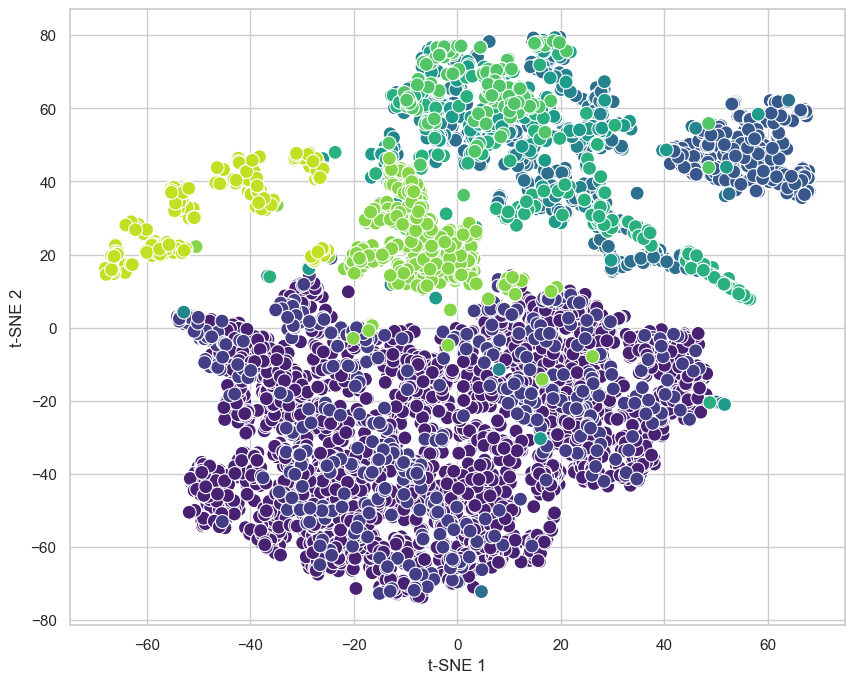

In [7]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

def plot_tsne(data, labels, title):
    """
    Plot t-SNE visualization of the data.
    """
    tsne = TSNE(n_components=2, random_state=42)
    data_2d = tsne.fit_transform(data)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=labels, palette="viridis", s=100, legend=False)
    
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    # Legend outside the plot
    # plt.legend(loc="upper left", title="Dataset", ncols=5, bbox_to_anchor=(1, 1))
    # plt.xlim(-95, 100)
    # plt.ylim(-78, 120)
    # NO LEGEND
    plt.show()

# Plot t-SNE for Cityscapes training set
index = 4
full_data = np.vstack([features_dict['train'][index], features_dict['val'][index], kitti_val_features[index], cifar10_val_features[index], fog_val_features[index], rain_val_features[index], sand_val_features[index], snow_val_features[index], cityscapes_fog_val_features[index], cityscapes_rain_val_features[index]])
print(kitti_val_features[index].shape)
plot_tsne(full_data, 
              ['Cityscapes Train (ID)'] * features_dict['train'][index].shape[0] +
           ['Cityscapes Val (ID)'] * features_dict['val'][index].shape[0] + 
             ['Kitti (OOD)'] * kitti_val_features[index].shape[0] +
             ['CIFAR10 (Far OOD)'] * cifar10_val_features[index].shape[0] +
             ['Fog (OOD)'] * fog_val_features[index].shape[0] +
             ['Rain (OOD)'] * rain_val_features[index].shape[0] +
             ['Sand (OOD)'] * sand_val_features[index].shape[0] +
             ['Snow (OOD)'] * snow_val_features[index].shape[0] +
             ['Cityscapes Fog (Near OOD)'] * cityscapes_fog_val_features[index].shape[0] +
             ['Cityscapes Rain (Near OOD)'] * cityscapes_rain_val_features[index].shape[0],
           "t-SNE Visualization of Features from Different Datasets")
# Plot t-SNE for Cityscapes validation set

In [198]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, roc_auc

def fpr_at_95_tpr(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    closest_tpr_idx = np.argmin(np.abs(tpr - 0.95))

    threshold = thresholds[closest_tpr_idx]
    return fpr[closest_tpr_idx], threshold


def tpr_and_fpr_at_threshold(y_true, y_scores, threshold):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    # given threshold is not a percentage but a score value
    closest_threshold_idx = np.argmin(np.abs(thresholds - threshold))

    tpr = tpr[closest_threshold_idx]
    fpr = fpr[closest_threshold_idx]
    return tpr, fpr

def get_confusion_matrix(y_true, y_scores, threshold=None):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    
    fscore = (2 * precision * recall) / (precision + recall)

    fscore[np.isnan(fscore)] = 0
    best_index = np.argmax(fscore)

    best_threshold = thresholds[best_index]
    best_precision = precision[best_index]
    best_recall = recall[best_index]
    best_fscore = fscore[best_index]

    ypred = (y_scores >= best_threshold).astype(int)
    cm = confusion_matrix(y_true, ypred)
    return cm, best_threshold, best_precision, best_recall, best_fscore


def compute_metrics(indices, split="val", threshold=None):
    id_scores, kitti_scores, cifar10_scores, fog_scores, rain_scores, snow_scores, sand_scores, cityscapes_fog_scores, cityscapes_rain_scores = compute_ood_scores(indices, split)
    # id_scores=np.asarray(val_scores).transpose().squeeze()
    ood_scores= np.concatenate([kitti_scores, cifar10_scores, fog_scores, rain_scores, snow_scores, sand_scores, cityscapes_fog_scores, cityscapes_rain_scores])
    ood_labels = np.concatenate([np.zeros_like(kitti_scores), np.zeros_like(cifar10_scores), 
                                  np.zeros_like(fog_scores), np.zeros_like(rain_scores), 
                                  np.zeros_like(snow_scores), np.zeros_like(sand_scores),
                                    np.zeros_like(cityscapes_fog_scores), np.zeros_like(cityscapes_rain_scores)])
    id_labels = np.ones_like(id_scores)

    print(id_scores.shape)
    print(ood_scores.shape)

    all_scores = np.concatenate([id_scores, ood_scores])
    all_labels = np.concatenate([id_labels, ood_labels])

    # Compute ROC AUC
    fpr, tpr, auc = plot_roc_curve(all_labels, all_scores, f"ROC Curve for {split == "val" and "Validation" or "Testing"} Set")
    roc_auc = roc_auc_score(all_labels, all_scores)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Compute Confusion Matrix and precision-Recall
    from sklearn.metrics import confusion_matrix, classification_report
    return roc_auc, fpr, tpr

In [51]:
scale_0_scores = []
scale_1_scores = []
scale_2_scores = []
scale_3_scores = []
scale_4_scores = []


split="val"
for i in range(len(features_dict['train'])):
    id_scores, kitti_scores, cifar10_scores, fog_scores, rain_scores, snow_scores, sand_scores, cityscapes_fog_scores, cityscapes_rain_scores = compute_ood_scores([i], split)
    # id_scores=np.asarray(val_scores).transpose().squeeze()
    ood_scores= np.concatenate([kitti_scores, cifar10_scores, fog_scores, rain_scores, snow_scores, sand_scores, cityscapes_fog_scores, cityscapes_rain_scores])
    all_scores = np.concatenate([id_scores, ood_scores])

    ood_labels = np.concatenate([np.zeros_like(kitti_scores), np.zeros_like(cifar10_scores), 
                                np.zeros_like(fog_scores), np.zeros_like(rain_scores), 
                                np.zeros_like(snow_scores), np.zeros_like(sand_scores),
                                np.zeros_like(cityscapes_fog_scores), np.zeros_like(cityscapes_rain_scores)])
    id_labels = np.ones_like(id_scores)
    all_labels = np.concatenate([id_labels, ood_labels])

    if i == 0:
        scale_0_scores = all_scores
    elif i == 1:
        scale_1_scores = all_scores
    elif i == 2:
        scale_2_scores = all_scores
    elif i == 3:
        scale_3_scores = all_scores
    elif i == 4:
        scale_4_scores = all_scores


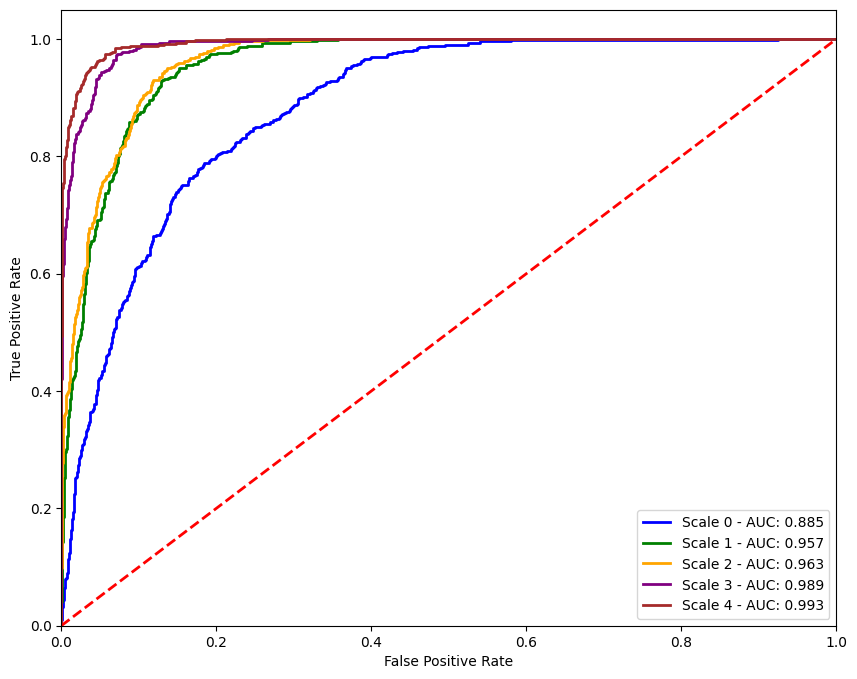

In [52]:
scale_0_fpr, scale_0_tpr, _ = roc_curve(all_labels, scale_0_scores)
scale_1_fpr, scale_1_tpr, _ = roc_curve(all_labels, scale_1_scores)
scale_2_fpr, scale_2_tpr, _ = roc_curve(all_labels, scale_2_scores)
scale_3_fpr, scale_3_tpr, _ = roc_curve(all_labels, scale_3_scores)
scale_4_fpr, scale_4_tpr, _ = roc_curve(all_labels, scale_4_scores)

plt.figure(figsize=(10, 8))
plt.plot(scale_0_fpr, scale_0_tpr, color='blue', lw=2, label='Scale 0 - AUC: {:.3f}'.format(roc_auc_score(all_labels, scale_0_scores)))
plt.plot(scale_1_fpr, scale_1_tpr, color='green', lw=2, label='Scale 1 - AUC: {:.3f}'.format(roc_auc_score(all_labels, scale_1_scores)))
plt.plot(scale_2_fpr, scale_2_tpr, color='orange', lw=2, label='Scale 2 - AUC: {:.3f}'.format(roc_auc_score(all_labels, scale_2_scores)))
plt.plot(scale_3_fpr, scale_3_tpr, color='purple', lw=2, label='Scale 3 - AUC: {:.3f}'.format(roc_auc_score(all_labels, scale_3_scores)))
plt.plot(scale_4_fpr, scale_4_tpr, color='brown', lw=2, label='Scale 4 - AUC: {:.3f}'.format(roc_auc_score(all_labels, scale_4_scores)))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [53]:
# FPR and TPR at 95% TPR
fpr_0, threshold_0 = fpr_at_95_tpr(all_labels, scale_0_scores)
fpr_1, threshold_1 = fpr_at_95_tpr(all_labels, scale_1_scores)
fpr_2, threshold_2 = fpr_at_95_tpr(all_labels, scale_2_scores)
fpr_3, threshold_3 = fpr_at_95_tpr(all_labels, scale_3_scores)
fpr_4, threshold_4 = fpr_at_95_tpr(all_labels, scale_4_scores)
print(f"Scale 0 - FPR at 95% TPR: {fpr_0:.4f}, Threshold: {threshold_0:.4f}")
print(f"Scale 1 - FPR at 95% TPR: {fpr_1:.4f}, Threshold: {threshold_1:.4f}")
print(f"Scale 2 - FPR at 95% TPR: {fpr_2:.4f}, Threshold: {threshold_2:.4f}")
print(f"Scale 3 - FPR at 95% TPR: {fpr_3:.4f}, Threshold: {threshold_3:.4f}")
print(f"Scale 4 - FPR at 95% TPR: {fpr_4:.4f}, Threshold: {threshold_4:.4f}")

Scale 0 - FPR at 95% TPR: 0.3672, Threshold: -5854.4259
Scale 1 - FPR at 95% TPR: 0.1524, Threshold: -41714.8530
Scale 2 - FPR at 95% TPR: 0.1359, Threshold: -24053.7941
Scale 3 - FPR at 95% TPR: 0.0620, Threshold: -16860.9752
Scale 4 - FPR at 95% TPR: 0.0372, Threshold: -30776.6163


In [56]:
confusion_matrix_0, best_threshold_0, precision_0, recall_0, f1_score_0 = get_confusion_matrix(all_labels, scale_0_scores)
confusion_matrix_1, best_threshold_1, precision_1, recall_1, f1_score_1 = get_confusion_matrix(all_labels, scale_1_scores)
confusion_matrix_2, best_threshold_2, precision_2, recall_2, f1_score_2 = get_confusion_matrix(all_labels, scale_2_scores)
confusion_matrix_3, best_threshold_3, precision_3, recall_3, f1_score_3 = get_confusion_matrix(all_labels, scale_3_scores)
confusion_matrix_4, best_threshold_4, precision_4, recall_4, f1_score_4 = get_confusion_matrix(all_labels, scale_4_scores)

print("Confusion Matrix for Scale 0:")
print(confusion_matrix_0)
print("Confusion Matrix for Scale 1:")
print(confusion_matrix_1)
print("Confusion Matrix for Scale 2:")
print(confusion_matrix_2)
print("Confusion Matrix for Scale 3:")
print(confusion_matrix_3)
print("Confusion Matrix for Scale 4:")
print(confusion_matrix_4)

# Compute precision and recall
from sklearn.metrics import precision_score, recall_score
def compute_precision_recall(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return precision, recall


print(f"Scale 0 - Precision: {precision_0:.4f}, Recall: {recall_0:.4f}, F1 Score: {f1_score_0:.4f}, Threshold: {best_threshold_0:.4f}")
print(f"Scale 1 - Precision: {precision_1:.4f}, Recall: {recall_1:.4f}, F1 Score: {f1_score_1:.4f}, Threshold: {best_threshold_1:.4f}")
print(f"Scale 2 - Precision: {precision_2:.4f}, Recall: {recall_2:.4f}, F1 Score: {f1_score_2:.4f}, Threshold: {best_threshold_2:.4f}")
print(f"Scale 3 - Precision: {precision_3:.4f}, Recall: {recall_3:.4f}, F1 Score: {f1_score_3:.4f}, Threshold: {best_threshold_3:.4f}")
print(f"Scale 4 - Precision: {precision_4:.4f}, Recall: {recall_4:.4f}, F1 Score: {f1_score_4:.4f}, Threshold: {best_threshold_4:.4f}")

Confusion Matrix for Scale 0:
[[2064  357]
 [ 130  370]]
Confusion Matrix for Scale 1:
[[2209  212]
 [  71  429]]
Confusion Matrix for Scale 2:
[[2185  236]
 [  56  444]]
Confusion Matrix for Scale 3:
[[2376   45]
 [  82  418]]
Confusion Matrix for Scale 4:
[[2374   47]
 [  47  453]]
Scale 0 - Precision: 0.5089, Recall: 0.7400, F1 Score: 0.6031, Threshold: 405.2298
Scale 1 - Precision: 0.6693, Recall: 0.8580, F1 Score: 0.7520, Threshold: 459.8355
Scale 2 - Precision: 0.6529, Recall: 0.8880, F1 Score: 0.7525, Threshold: 220.7099
Scale 3 - Precision: 0.9028, Recall: 0.8360, F1 Score: 0.8681, Threshold: 319.5710
Scale 4 - Precision: 0.9060, Recall: 0.9060, F1 Score: 0.9060, Threshold: 159.7659


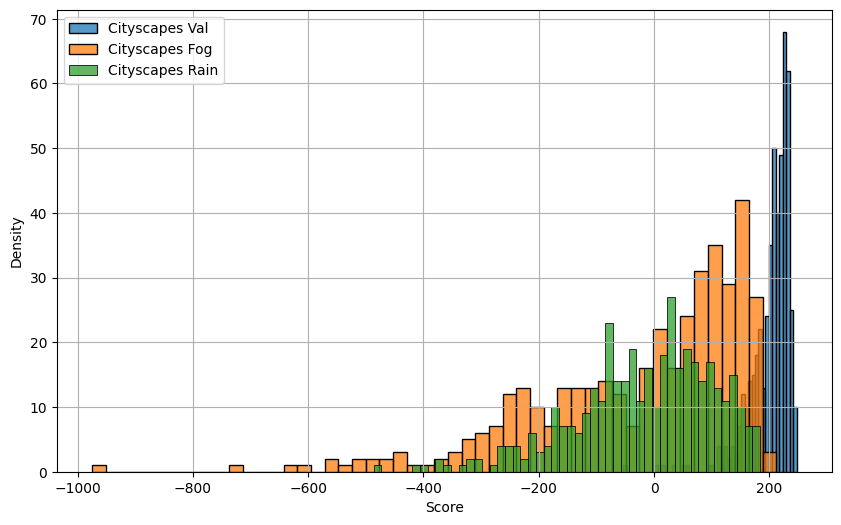

In [189]:
# Plot the scores
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
# sns.histplot(total_feats_score, bins=50, kde=True, label='Cityscapes Train')
sns.histplot(total_vals_score, bins=50, label='Cityscapes Val')
# sns.histplot(total_kitti_score, bins=50, kde=True, label='Kitti')
# sns.histplot(total_cifar10_score, bins=50, kde=True, label='CIFAR10')
# sns.histplot(total_fog_score, bins=50, kde=True, label='Fog')
# sns.histplot(total_rain_score, bins=50, kde=True, label='Rain')
# sns.histplot(total_snow_score, bins=50, kde=True, label='Snow')
# sns.histplot(total_sand_score, bins=50, kde=True, label='Sand')
sns.histplot(total_cityscapes_fog_score, bins=50, label='Cityscapes Fog')
sns.histplot(total_cityscapes_rain_score, bins=50, label='Cityscapes Rain')
plt.xlabel('Score')
plt.ylabel('Density')
# plt.xlim(-1000, 500)
plt.legend()
plt.grid()
plt.show()



# Multi-scale

In [26]:
id_score=compute_ood_scores_multi_scale(features_dict['val'], gmms)
kitti_score=compute_ood_scores_multi_scale(kitti_val_features, gmms)
cifar10_score=compute_ood_scores_multi_scale(cifar10_val_features, gmms)
fog_score=compute_ood_scores_multi_scale(fog_val_features, gmms)
rain_score=compute_ood_scores_multi_scale(rain_val_features, gmms)
snow_score=compute_ood_scores_multi_scale(snow_val_features, gmms)
sand_score=compute_ood_scores_multi_scale(sand_val_features, gmms)
cityscapes_fog_score=compute_ood_scores_multi_scale(cityscapes_fog_val_features, gmms)
cityscapes_rain_score=compute_ood_scores_multi_scale(cityscapes_rain_val_features, gmms)

 
thresholds = []
scales_scores=[]
scales_labels=[]
for i in range(len(id_score)):
    all_labels = np.concatenate([np.zeros_like(id_score[i]), np.ones_like(kitti_score[i]),
                                  np.ones_like(cifar10_score[i]), np.ones_like(fog_score[i]),
                                  np.ones_like(rain_score[i]), np.ones_like(snow_score[i]),
                                  np.ones_like(sand_score[i]), np.ones_like(cityscapes_fog_score[i]),
                                  np.ones_like(cityscapes_rain_score[i])])
    all_scores = np.concatenate([id_score[i], kitti_score[i], cifar10_score[i], fog_score[i],
                                    rain_score[i], snow_score[i], sand_score[i], cityscapes_fog_score[i],
                                    cityscapes_rain_score[i]])
    scales_scores.append(all_scores)
    scales_labels.append(all_labels)
    fpr, threshold = fpr_at_95_tpr(all_labels, all_scores)
    thresholds.append(threshold)
    print(f"Threshold for scale {i}: {threshold:.4f}")

Threshold for scale 0: -4860.5941
Threshold for scale 1: -36111.6953
Threshold for scale 2: -19510.0066
Threshold for scale 3: -11884.9255
Threshold for scale 4: -11448.9881


In [89]:
thresholds = [best_threshold_0, best_threshold_1, best_threshold_2, best_threshold_3, best_threshold_4]
id_score=compute_ood_scores_multi_scale(features_dict['val'], gmms)
kitti_score=compute_ood_scores_multi_scale(kitti_val_features, gmms)
cifar10_score=compute_ood_scores_multi_scale(cifar10_val_features, gmms)
fog_score=compute_ood_scores_multi_scale(fog_val_features, gmms)
rain_score=compute_ood_scores_multi_scale(rain_val_features, gmms)
snow_score=compute_ood_scores_multi_scale(snow_val_features, gmms)
sand_score=compute_ood_scores_multi_scale(sand_val_features, gmms)
cityscapes_fog_score=compute_ood_scores_multi_scale(cityscapes_fog_val_features, gmms)
cityscapes_rain_score=compute_ood_scores_multi_scale(cityscapes_rain_val_features, gmms)

ood_scores_list = [kitti_score, cifar10_score, fog_score, rain_score, snow_score, sand_score, cityscapes_fog_score, cityscapes_rain_score]

def get_predictions(feature_maps):
    transposed_id_score = np.array(id_score).transpose()
    id_predictions = []
    for i in range(len(transposed_id_score)):
        scales_predictions = []
        for j in range(len(transposed_id_score[i])):
            if j not in feature_maps:
                continue
            if transposed_id_score[i][j] < thresholds[j]:
                scales_predictions.append(1) # 1 is OOD
            else:
                scales_predictions.append(0)
        if sum(scales_predictions) >= 2:
            id_predictions.append(1)
        else:
            id_predictions.append(0)

    ood_predictions = []
    for i in range(len(ood_scores_list)):
        transposed_scores_list = np.array(ood_scores_list[i]).transpose()
        for j in range(len(transposed_scores_list)):
            scales_predictions = []
            for k in range(len(transposed_scores_list[j])):
                if k not in feature_maps:
                    continue
                if transposed_scores_list[j][k] < thresholds[k]:
                    scales_predictions.append(1)
                else:
                    scales_predictions.append(0)
            if sum(scales_predictions) >= 2:
                ood_predictions.append(1)
            else:
                ood_predictions.append(0)
    ood_predictions = np.array(ood_predictions)

    return id_predictions, ood_predictions

def compute_multi_scales_metrics(id_predictions, ood_predictions):
    TP=len(id_predictions)-np.sum(id_predictions)
    P=len(id_predictions)
    FN=np.where(ood_predictions == 0)[0].shape[0]

    recall=TP/P
    precision=TP/(TP+FN)
    f1=2*precision*recall/(precision+recall)

    return recall, precision, f1

In [90]:
id_preds_1, ood_preds_1 = get_predictions([0, 1, 2, 3, 4])
id_preds_2, ood_preds_2 = get_predictions([0, 1])
id_preds_3, ood_preds_3 = get_predictions([2, 3])
id_preds_4, ood_preds_4 = get_predictions([3, 4])
id_preds_5, ood_preds_5 = get_predictions([2, 3, 4])

recall_0, precision_0, f1_0 = compute_multi_scales_metrics(id_preds_1, ood_preds_1)
recall_1, precision_1, f1_1 = compute_multi_scales_metrics(id_preds_2, ood_preds_2)
recall_2, precision_2, f1_2 = compute_multi_scales_metrics(id_preds_3, ood_preds_3)
recall_3, precision_3, f1_3 = compute_multi_scales_metrics(id_preds_4, ood_preds_4)
recall_4, precision_4, f1_4 = compute_multi_scales_metrics(id_preds_5, ood_preds_5)

print(f"For all scales: Recall: {recall_0:.4f}, Precision: {precision_0:.4f}, F1 Score: {f1_0:.4f}")
print(f"For coarse scales (0 + 1): Recall: {recall_1:.4f}, Precision: {precision_1:.4f}, F1 Score: {f1_1:.4f}")
print(f"For medium scales (2 + 3): Recall: {recall_2:.4f}, Precision: {precision_2:.4f}, F1 Score: {f1_2:.4f}")
print(f"For fine scales (3 + 4): Recall: {recall_3:.4f}, Precision: {precision_3:.4f}, F1 Score: {f1_3:.4f}")
print(f"For medium scales (2 + 3 + 4): Recall: {recall_4:.4f}, Precision: {precision_4:.4f}, F1 Score: {f1_4:.4f}")

For all scales: Recall: 0.8200, Precision: 0.9011, F1 Score: 0.8586
For coarse scales (0 + 1): Recall: 0.9220, Precision: 0.5263, F1 Score: 0.6701
For medium scales (2 + 3): Recall: 0.9100, Precision: 0.6585, F1 Score: 0.7641
For fine scales (3 + 4): Recall: 0.9240, Precision: 0.8783, F1 Score: 0.9006
For medium scales (2 + 3 + 4): Recall: 0.8780, Precision: 0.8851, F1 Score: 0.8815


## Concatenated features

In [248]:
concatenated_features = np.concatenate(features_dict['train'][2:], axis=1)
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
gmm.fit(concatenated_features)

GaussianMixture(n_components=10, random_state=42)

In [ ]:
concatenated_val_features = np.concatenate(features_dict['val'][3:], axis=1)
val_scores = gmm.score_samples(concatenated_val_features)

In [250]:
concatenated_cityscapes_fog_val_features = np.concatenate(cityscapes_fog_val_features[2:], axis=1)
cityscapes_fog_val_scores = gmm.score_samples(concatenated_cityscapes_fog_val_features)
concatenated_cityscapes_rain_val_features = np.concatenate(cityscapes_rain_val_features[2:], axis=1)
cityscapes_rain_val_scores = gmm.score_samples(concatenated_cityscapes_rain_val_features)
concatenated_kitti_val_features = np.concatenate(kitti_val_features[2:], axis=1)
kitti_val_scores = gmm.score_samples(concatenated_kitti_val_features)
concatenated_cifar10_val_features = np.concatenate(cifar10_val_features[2:], axis=1)
cifar10_val_scores = gmm.score_samples(concatenated_cifar10_val_features)
concatenated_fog_val_features = np.concatenate(fog_val_features[2:], axis=1)
fog_val_scores = gmm.score_samples(concatenated_fog_val_features)
concatenated_rain_val_features = np.concatenate(rain_val_features[2:], axis=1)
rain_val_scores = gmm.score_samples(concatenated_rain_val_features)
concatenated_snow_val_features = np.concatenate(snow_val_features[2:], axis=1)
snow_val_scores = gmm.score_samples(concatenated_snow_val_features)
concatenated_sand_val_features = np.concatenate(sand_val_features[2:], axis=1)
sand_val_scores = gmm.score_samples(concatenated_sand_val_features)

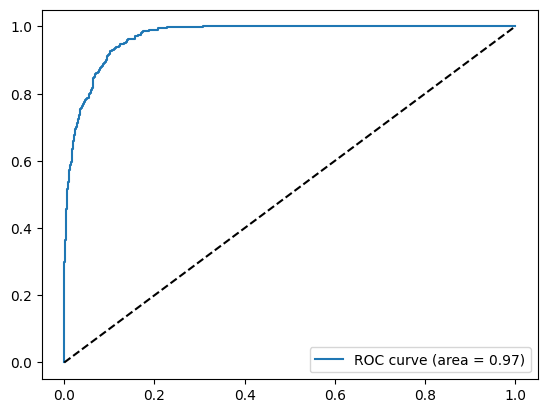

In [251]:
all_labels = np.concatenate([np.ones_like(val_scores), np.zeros_like(kitti_val_scores),
                            np.zeros_like(cifar10_val_scores), np.zeros_like(fog_val_scores),
                            np.zeros_like(rain_val_scores), np.zeros_like(snow_val_scores),
                            np.zeros_like(sand_val_scores), np.zeros_like(cityscapes_fog_val_scores),
                            np.zeros_like(cityscapes_rain_val_scores)])
all_scores = np.concatenate([val_scores, kitti_val_scores, cifar10_val_scores, fog_val_scores,
                            rain_val_scores, snow_val_scores, sand_val_scores,
                            cityscapes_fog_val_scores, cityscapes_rain_val_scores])
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = roc_auc_score(all_labels, all_scores)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")

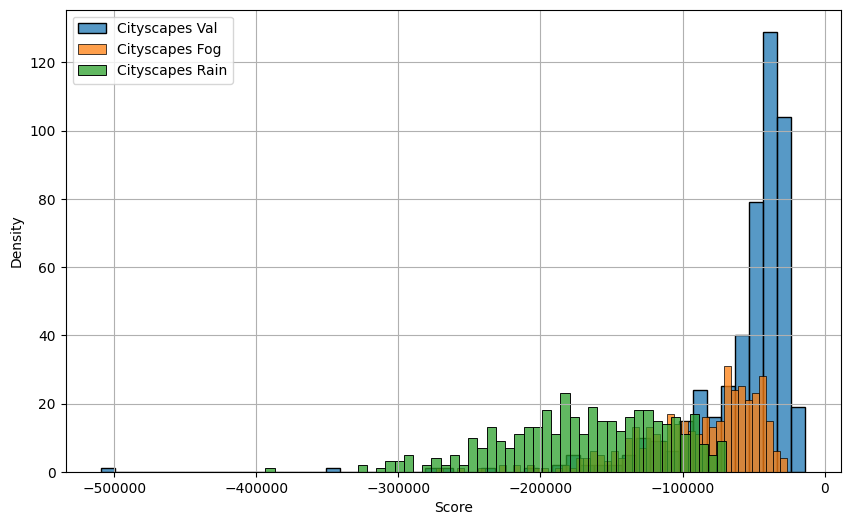

In [227]:
# Plot the scores
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
# sns.histplot(total_feats_score, bins=50, kde=True, label='Cityscapes Train')
sns.histplot(val_scores, bins=50, label='Cityscapes Val')
sns.histplot(cityscapes_fog_val_scores, bins=50, label='Cityscapes Fog')
sns.histplot(cityscapes_rain_val_scores, bins=50, label='Cityscapes Rain')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()



In [228]:
all_labels = np.concatenate([np.zeros_like(id_predictions), np.ones_like(ood_predictions)])
all_scores = np.concatenate([id_predictions, ood_predictions])
confusion_matrix_0, best_threshold_0, precision_0, recall_0, f1_score_0 = get_confusion_matrix(all_labels, all_scores)

/var/folders/kq/ygzwvybx0xvfj4xx0rm_33rh0000gn/T/ipykernel_48368/2961493855.py:45: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


Best Threshold: -38099.5452, Precision: 0.7368, Recall: 0.7840, F1 Score: 0.7597
Best Threshold: -14854.0501, Precision: 0.6453, Recall: 0.8440, F1 Score: 0.7314
Best Threshold: -182.4640, Precision: 0.8337, Recall: 0.7820, F1 Score: 0.8070
Best Threshold: 430.8230, Precision: 0.8782, Recall: 0.8220, F1 Score: 0.8492


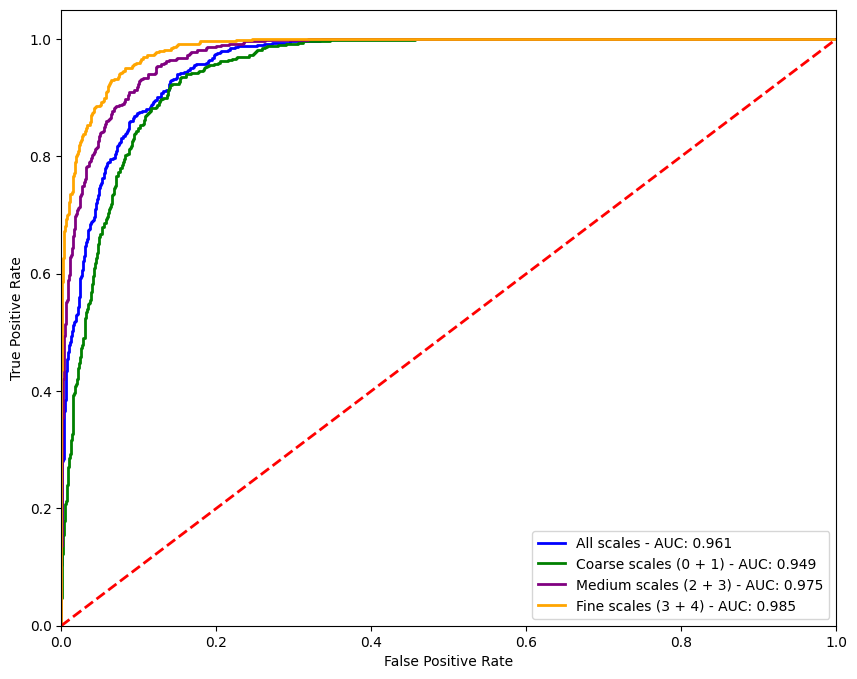

In [258]:
fprs=[]
tprs=[]
scores=[]
EXPERIMENTS=[[0, 1, 2, 3, 4], [0, 1], [2, 3], [3, 4]]
for i in range(len(EXPERIMENTS)):
    concatenated_features = np.concatenate([features_dict['train'][i] for i in EXPERIMENTS[i]], axis=1)
    gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
    gmm.fit(concatenated_features)

    concatenated_val_features = np.concatenate([features_dict['val'][i] for i in EXPERIMENTS[i]], axis=1)
    val_scores = gmm.score_samples(concatenated_val_features)
    concatenated_kitti_val_features = np.concatenate([kitti_val_features[i] for i in EXPERIMENTS[i]], axis=1)
    kitti_val_scores = gmm.score_samples(concatenated_kitti_val_features)
    concatenated_cifar10_val_features = np.concatenate([cifar10_val_features[i] for i in EXPERIMENTS[i]], axis=1)
    cifar10_val_scores = gmm.score_samples(concatenated_cifar10_val_features)
    concatenated_fog_val_features = np.concatenate([fog_val_features[i] for i in EXPERIMENTS[i]], axis=1)
    fog_val_scores = gmm.score_samples(concatenated_fog_val_features)
    concatenated_rain_val_features = np.concatenate([rain_val_features[i] for i in EXPERIMENTS[i]], axis=1)
    rain_val_scores = gmm.score_samples(concatenated_rain_val_features)
    concatenated_snow_val_features = np.concatenate([snow_val_features[i] for i in EXPERIMENTS[i]], axis=1)
    snow_val_scores = gmm.score_samples(concatenated_snow_val_features)
    concatenated_sand_val_features = np.concatenate([sand_val_features[i] for i in EXPERIMENTS[i]], axis=1)
    sand_val_scores = gmm.score_samples(concatenated_sand_val_features)
    concatenated_cityscapes_fog_val_features = np.concatenate([cityscapes_fog_val_features[i] for i in EXPERIMENTS[i]], axis=1)
    cityscapes_fog_val_scores = gmm.score_samples(concatenated_cityscapes_fog_val_features)
    concatenated_cityscapes_rain_val_features = np.concatenate([cityscapes_rain_val_features[i] for i in EXPERIMENTS[i]], axis=1)
    cityscapes_rain_val_scores = gmm.score_samples(concatenated_cityscapes_rain_val_features)
    
    all_labels = np.concatenate([np.ones_like(val_scores), np.zeros_like(kitti_val_scores),
                                np.zeros_like(cifar10_val_scores), np.zeros_like(fog_val_scores),
                                np.zeros_like(rain_val_scores), np.zeros_like(snow_val_scores),
                                np.zeros_like(sand_val_scores), np.zeros_like(cityscapes_fog_val_scores),
                                np.zeros_like(cityscapes_rain_val_scores)])
    all_scores = np.concatenate([val_scores, kitti_val_scores, cifar10_val_scores, fog_val_scores,
                                rain_val_scores, snow_val_scores, sand_val_scores,
                                cityscapes_fog_val_scores, cityscapes_rain_val_scores])
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = roc_auc_score(all_labels, all_scores)
    fprs.append(fpr)
    tprs.append(tpr)
    scores.append(all_scores)

    precision, recall, thresholds = precision_recall_curve(all_labels, all_scores)

    fscore = (2 * precision * recall) / (precision + recall)
    fscore[np.isnan(fscore)] = 0
    best_index = np.argmax(fscore)
    best_threshold = thresholds[best_index]
    best_precision = precision[best_index]
    best_recall = recall[best_index]
    best_fscore = fscore[best_index]
    print(f"Best Threshold: {best_threshold:.4f}, Precision: {best_precision:.4f}, Recall: {best_recall:.4f}, F1 Score: {best_fscore:.4f}")

    

    
plt.figure(figsize=(10, 8))
plt.plot(fprs[0], tprs[0], color='blue', lw=2, label='All scales - AUC: {:.3f}'.format(roc_auc_score(all_labels, scores[0])))
plt.plot(fprs[1], tprs[1], color='green', lw=2, label='Coarse scales (0 + 1) - AUC: {:.3f}'.format(roc_auc_score(all_labels, scores[1])))
plt.plot(fprs[2], tprs[2], color='purple', lw=2, label='Medium scales (2 + 3) - AUC: {:.3f}'.format(roc_auc_score(all_labels, scores[2])))
plt.plot(fprs[3], tprs[3], color='orange', lw=2, label='Fine scales (3 + 4) - AUC: {:.3f}'.format(roc_auc_score(all_labels, scores[3])))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
